<a href="https://colab.research.google.com/github/lowbee2019/Algorithm/blob/master/MyModel-Result-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emnist

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import collections
import copy
import random
import emnist

# Server Initialization

In [ ]:
class ParamServer(object):
  def __init__(self,init_model_path):
    self.init_model_path = init_model_path
    self.round = 0
    self.optimizer="adam"
    self.loss = "sparse_categorical_crossentropy"
    self.metrics =['accuracy']
    self.loss_acc=[]

  def PreTrain(self,model,data,labels,batch_size=32,epochs=5):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    _metrics = model.fit(data,labels,batch_size,epochs)
    return model
  
  def PreEval(self,model,test_data,test_labels):
    model.compile(optimizer=self.optimizer,
                  loss=self.loss,
                  metrics=self.metrics)
    self.loss_acc.append(model.evaluate(test_data,test_labels))


## Mnist数据集的预处理

In [ ]:
mnist = tf.keras.datasets.mnist
train,test = mnist.load_data()
x_train,y_train = train
x_test,y_test = test
x_train,x_test = x_train/255.0,x_test/255.0

In [ ]:
x_train.shape

(60000, 28, 28)

## 模型的定义

In [ ]:
class FLModel(tf.keras.Model):
  def __init__(self,row,col,num_classes=62,*args,**kwargs):
    super(FLModel,self).__init__(*args,**kwargs)
    self.row = row
    self.col = col
    self.num_classes = num_classes
    self.flatten = tf.keras.layers.Flatten(input_shape=(row,col))
    self.dense_1 = tf.keras.layers.Dense(500,activation='relu',name="dense_1")
    self.dense_2 = tf.keras.layers.Dense(num_classes,activation='softmax',name="dense_2")
    self.drop = tf.keras.layers.Dropout(0.2)


  def call(self,inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.drop(x)
    x = self.dense_2(x)
    return x
  
  def copy(self):
    NewModel = FLModel(self.row,self.col,self.num_classes)
    _ = NewModel(np.expand_dims(tf.zeros([self.row,self.col]),0))
    ##Layers
    NewVars = NewModel.trainable_variables #此处为空列表，因为没有训练,这个地方参数传递是不是有问题
    OldVars = self.trainable_variables
    for n,o in zip(NewVars,OldVars):
      n.assign(o.numpy())
    return NewModel

  # def compute_output_shape(self,input_shape):
  #   shape = tf.TensorShape(input_shape).as_list()
  #   shape[-1] = self.num_classes
  #   return tf.TensorShape(shape)

#Client Initialization
模型训练和评估都要重写

In [ ]:
class Client(object):
  def __init__(self,id,model=None,Train_dataset=None,Test_dataset=None):
    self.id = id
    self.model = model
    self.Train_dataset = Train_dataset
    self.Test_dataset = Test_dataset
    # from ParamServer
    self.ParamModel = None
    self.num_epochs = 5
    self.batch_size = 32
    self.shuffle_buffer = 100
    self.prefetch_buffer = 10
    ## 


  def ReceiveModel(self,ParamModel,num_epochs=1,batch_size=32,shuffle_buffer=100,prefetch_buffer=10):
    self.ParamModel = ParamModel
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.shuffle_buffer = shuffle_buffer
    self.prefetch_buffer = prefetch_buffer
  

  def preprocess(self,dataset):
    def batch_format_fn(element):
      return collections.OrderedDict(
            
            x = tf.reshape(element['pixels'],[-1,784]),
            y = tf.reshape(element['label'],[-1,1])
          )
    return dataset.repeat(self.num_epochs).shuffle(self.shuffle_buffer).batch(
        self.batch_size).map(batch_format_fn).prefetch(self.prefetch_buffer)

  def NodeTrain(self):
    model = self.ParamModel
    # pre_data = self.preprocess(self.Train_dataset)
    # print(type(pre_data))
    # model.fit(x=pre_data['x'],y=pre_data['y'],batch_size=self.batch_size,epochs=self.num_epochs)
    # x = np.array([i['pixels'].numpy() for i in self.Train_dataset])
    # y = np.array([i['label'].numpy() for i in self.Train_dataset])
    x,y = self.Train_dataset
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    _metrics = model.fit(x,y,batch_size=self.batch_size,epochs=self.num_epochs)
    self.model = model

  def NodeEval(self):
    x,y = self.Test_dataset
    self.model.evaluate(x,y)


# 阶段一：为Client分配数据（预处理工作）

#阶段一：服务器完成模型初始化

In [ ]:
# emnist_dataset = emnist.extract_training_samples('byclass')

In [ ]:
emnist_dataset = emnist.extract_training_samples('letters')

In [ ]:
emnist_dataset = (emnist_dataset[0]/255.0,emnist_dataset[1]+9)

In [ ]:
set(emnist_dataset[1])

{10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35}

In [ ]:
def create_data_for_clients(BasicSet,Num,TuneSet=train,TargetRate=0.7):
  #Alpha: 需要掺入mnist的占比
  #Beta: Emnist中数字的占比
  # Beta = 34.0/73.0
  Beta = 0
  if TargetRate < Beta:
    Alpha = 0
  else:
    Alpha = (TargetRate-Beta)/(1-Beta)
  TuneNum = int(Alpha*Num)
  BasicNum = Num-TuneNum
  x_sequence = []
  y_sequence = []
  print(TuneNum,BasicNum)
  if TuneNum > 0:
    for i in range(TuneNum):
      index = random.randint(0,len(TuneSet[0])-1)
      x_sequence.append(TuneSet[0][index])
      y_sequence.append(TuneSet[1][index])
  if BasicNum > 0:
    for i in range(BasicNum):
      index = random.randint(0,len(BasicSet[0])-1)
      x_sequence.append(BasicSet[0][index])
      y_sequence.append(BasicSet[1][index])
  return (np.array(x_sequence),np.array(y_sequence))

In [ ]:
# def create_data_for_clients(BasicSet,Num):
#   x_sequence = []
#   y_sequence = []
#   for i in range(Num):
#     index = random.randint(0,Num-1)
#     x_sequence.append(BasicSet[0][index])
#     y_sequence.append(BasicSet[1][index])
#   return (np.array(x_sequence),np.array(y_sequence))

In [ ]:
NUM_CLIENTS = 12
NUM_TRAIN_SAMPLE_CLIENT = 2560
NUM_TEST_SAMPLE_CLIENT = 256

In [ ]:
clients=[]
for i in range(NUM_CLIENTS):
  clients.append(Client(i,
                        Train_dataset=create_data_for_clients(emnist_dataset,NUM_TRAIN_SAMPLE_CLIENT,TargetRate=random.random()),
                        Test_dataset=create_data_for_clients(emnist_dataset,NUM_TEST_SAMPLE_CLIENT))
  )

2143 417
179 77
2057 503
179 77
619 1941
179 77
1114 1446
179 77
96 2464
179 77
898 1662
179 77
800 1760
179 77
274 2286
179 77
1359 1201
179 77
1151 1409
179 77
1385 1175
179 77
372 2188
179 77


Show DataSet

In [ ]:
import matplotlib.pyplot as plt

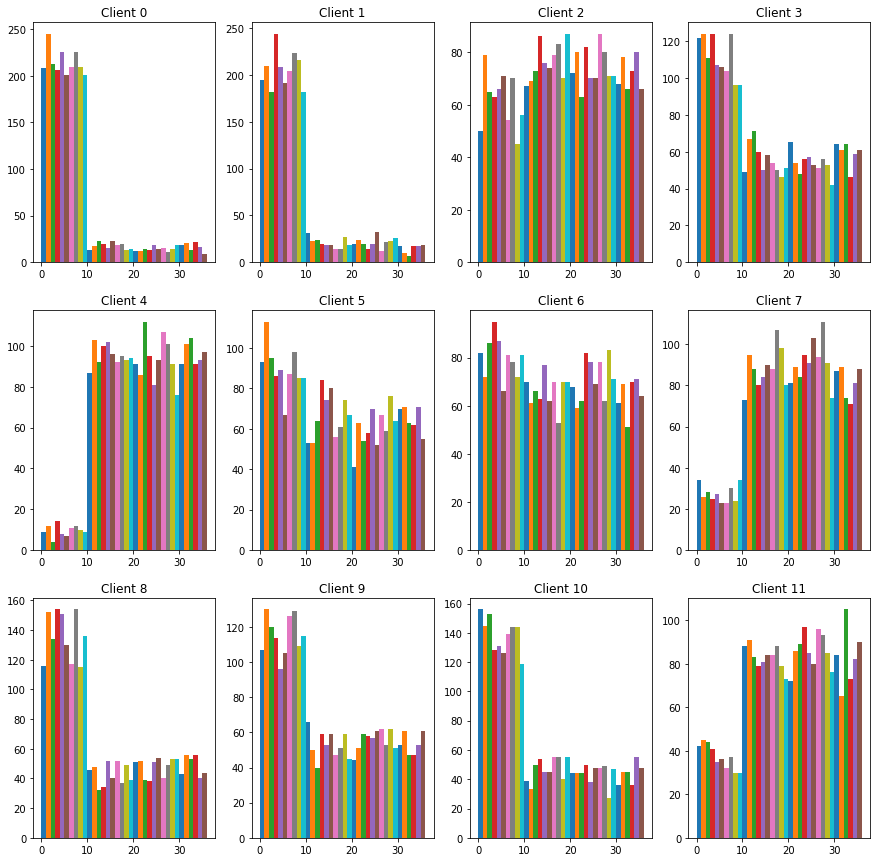

In [ ]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = collections.defaultdict(list)
  for label in client_dataset[1]:
    plot_data[label].append(label)
  plt.subplot(3,4,i+1)
  plt.title('Client {}'.format(i))
  for j in range(len(plot_data)):
    plt.hist(
        plot_data[j],
        density = False,
        bins = [x for x in range(len(plot_data)+1)]
    )

显示一下数字与字母的对比


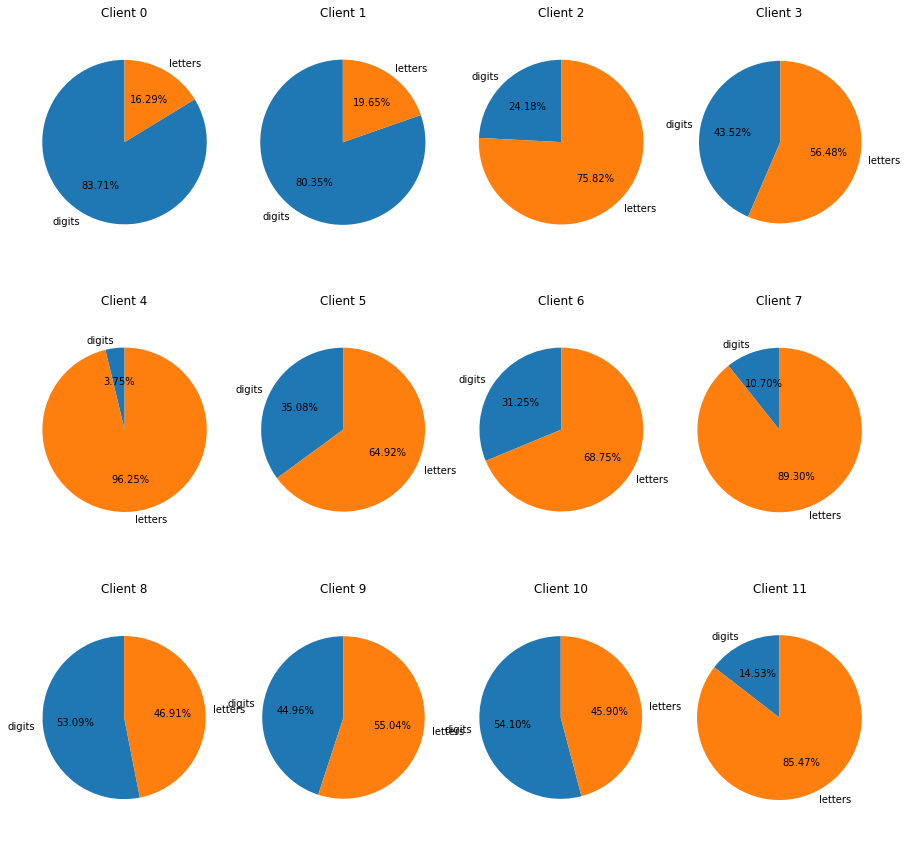

In [ ]:
f = plt.figure(figsize=(15,15))
for i in range(NUM_CLIENTS):
  client_dataset = clients[i].Train_dataset
  plot_data = {0:0,1:0}
  plot_labels = ['digits','letters']
  for label in client_dataset[1]:
    label = 0 if label < 10 else 1
    plot_data[label]+=1
  # print(plot_data)
  data_labels = list(sorted(plot_data.keys()))
  # print(data_labels)
  data_nums = [plot_data[i] for i in data_labels]
  colors = ['red','blue']
  plt.subplot(3,4,i+1)
  patches,text1,text2 = plt.pie(data_nums,
                              labels=plot_labels,
                              autopct='%3.2f%%',
                              shadow=False,
                              startangle=90,
                              pctdistance=0.6)
  plt.axis('equal')
  plt.title('Client {}'.format(i))
plt.show()


##阶段二：中央服务器下发模型

Distance Between two models

In [ ]:
def Distance(HookModel,TestModel):
  len_it = len(HookModel.trainable_variables)
  Hook_weights=[]
  Test_weights=[]
  for index in range(len_it):
    Hook_weights.append(HookModel.trainable_variables[index].numpy())
    Test_weights.append(TestModel.trainable_variables[index].numpy())
  target = []
  dis_norm2=[]
  for i in range(len_it):
    target.append(Hook_weights[i]-Test_weights[i])
    dis_norm2.append(np.linalg.norm(target[i],2))
  weight_weights = np.ones([len_it,1])
  #调整权重
  # weight_weights[0]=0
  # weight_weights[1]=0
  dis = np.dot(dis_norm2,weight_weights)
  return dis
  # return dis_norm2

In [ ]:
def BetterNode(clients,model,Total_NUM,FedAvg_NUM):
  NodeDict=collections.OrderedDict()
  for i in range(Total_NUM):
    NodeDict[i] = Distance(model,clients[i].model)
  Dlst = sorted(NodeDict.items(),key=lambda x:x[1])
  NodeList = []
  for i in range(FedAvg_NUM):
    NodeList.append(Dlst[i][0])
  return NodeList

模型初始化

In [ ]:
InitModel = FLModel(row=28,col=28,num_classes=36)
S = ParamServer("")

In [ ]:
S.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 3.6183 - accuracy: 0.0366


In [ ]:
SendModel = S.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.9945 - accuracy: 0.5533


# 阶段三：Clients 训练节点数据并聚合


In [ ]:
def FedAvg(NUM_CLIENTS,model,FedAvg_NUM=7):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  FedNodeList=BetterNode(clients,iterModel,NUM_CLIENTS,FedAvg_NUM)
  print("FedAvg Node is",FedNodeList)
  # Cut=2
  # for c in range(Cut):
  #   # tmp =np.array(iterModel.trainable_variables[c].numpy(),dtype='float64')
  #   all_weights.append(iterModel.trainable_variables[c].numpy())

  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')

    for node in FedNodeList:
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/FedAvg_NUM)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return (iterModel,FedNodeList)

In [ ]:
NUM_EPOCHS = 20

In [ ]:
NodeList = []
participator=NUM_CLIENTS
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy(),)
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  if participator < int(0.7*NUM_CLIENTS):
    participator = int(0.7*NUM_CLIENTS) 
  FedModel,li = FedAvg(NUM_CLIENTS,SendModel,FedAvg_NUM=participator)
  participator = participator-1
  NodeList.append(li)
  S.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
80/80 [==============================] - 1s 5ms/step - loss: 15.6719 - accuracy: 0.1480
FedAvg Node is [0, 1, 10, 8, 9, 6, 5, 3, 11, 2, 7, 4]
313/313 [==============================] - 1s 2ms/step - loss: 2.4331 - accuracy: 0.8544
EPOCHS 1 is starting...
80/80 [==============================] - 1s 5ms/step - loss: 7.4155 - accuracy: 0.3398
FedAvg Node is [1, 0, 10, 8, 9, 3, 6, 2, 5, 11, 7]
313/313 [==============================] - 1s 2ms/step - loss: 2.5978 - accuracy: 0.8894
EPOCHS 2 is starting...
80/80 [==============================] - 1s 5ms/step - loss: 5.1511 - accuracy: 0.4631
FedAvg Node is [1, 0, 8, 9, 10, 6, 3, 2, 5, 11]
313/313 [==============================] - 1s 2ms/step - loss: 2.5530 - accuracy: 0.8874
EPOCHS 3 is starting...
80/80 [==============================] - 1s 5ms/step - loss: 4.6688 - accuracy: 0.5107
FedAvg Node is [1, 10, 0, 3, 8, 9, 5, 6, 2]
313/313 [==============================] - 1s 2ms/step - loss: 2.4722 - accuracy: 0.8922
EP

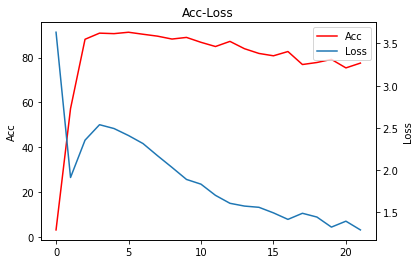

In [ ]:
#deal the data
S_acc =[S.loss_acc[i][1]*100 for i in range(len(S.loss_acc))]
S_loss =[S.loss_acc[i][0] for i in range(len(S.loss_acc))]

#prepare show image
x = np.arange(len(S.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

In [ ]:
NodeList

[[0, 1, 8, 10, 9, 3, 6, 2, 5, 11, 7, 4],
 [0, 1, 8, 10, 9, 3, 6, 5, 2, 11, 7],
 [0, 1, 10, 9, 8, 3, 2, 5, 6, 11],
 [0, 10, 8, 1, 3, 9, 2, 6, 5],
 [0, 1, 10, 8, 5, 9, 3, 6],
 [1, 0, 10, 9, 3, 8, 5, 2],
 [0, 1, 10, 8, 9, 3, 5, 2],
 [0, 8, 10, 1, 3, 9, 6, 2],
 [1, 0, 8, 10, 9, 3, 6, 2],
 [10, 1, 0, 9, 8, 3, 2, 6]]

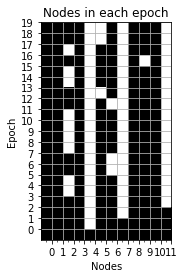

In [ ]:
#deal the data
img = np.ones(shape=(NUM_EPOCHS,NUM_CLIENTS),dtype=int)
for i in range(len(NodeList)):
  for j in NodeList[i]:
    img[i][j]=0
#prepare show image
len_n = len(S.loss_acc)
ax = plt.gca()
ax.set_xlim(-0.5,NUM_CLIENTS-0.5)
ax.set_ylim(-0.5,9.5)
miloc = plt.MultipleLocator(1)
ax.xaxis.set_minor_locator(miloc)
plt.grid()
plt.title("Nodes in each epoch")
plt.imshow(img*255,cmap='gray')
plt.axis('on')
plt.xlabel('Nodes')
plt.ylabel('Epoch')
x = np.arange(0.5,NUM_CLIENTS+0.5,1)
y = np.arange(0.5,NUM_EPOCHS+0.5,1)
plt.xticks()
plt.yticks(y,(int(i-0.5) for i in y))
plt.xticks(x,(int(i-0.5) for i in x))
plt.show()

设置对照组，即普通的FedAvg

In [ ]:
def FedAvg_Baseline(NUM_CLIENTS,model):
  iterModel = model.copy()
  len_it = len(iterModel.trainable_variables)
  all_weights = []
  for weights_index in range(len_it):
    tmp =np.zeros(iterModel.trainable_variables[weights_index].numpy().shape,dtype='float64')
    for node in range(NUM_CLIENTS):
      tmp += clients[node].model.trainable_variables[weights_index].numpy()
    all_weights.append(tmp/NUM_CLIENTS)
  # print(all_weights)
  iterModel_vars = iterModel.trainable_variables
  for iter_v,n in zip(iterModel_vars,all_weights):
    iter_v.assign(n)
  return iterModel

In [ ]:
InitModel = FLModel(row=28,col=28,num_classes=36)
S2 = ParamServer("")
S2.PreEval(InitModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 3.7367 - accuracy: 0.0058


In [ ]:
SendModel = S2.PreTrain(InitModel,x_train[0:200],y_train[0:200],epochs=1)
S2.PreEval(SendModel,x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.9914 - accuracy: 0.5685


In [ ]:
NUM_EPOCHS = 20

In [ ]:
for e in range(NUM_EPOCHS):
  print("EPOCHS {} is starting...".format(e))
  for i in range(NUM_CLIENTS):
    clients[i].ReceiveModel(SendModel.copy())
    clients[i].NodeTrain()
    # clients[i].NodeEval()
    # DIS.append(Distance(SendModel,clients[i].model))
  FedModel = FedAvg_Baseline(NUM_CLIENTS,SendModel)
  S2.PreEval(FedModel,x_test,y_test)
  SendModel = FedModel.copy()

EPOCHS 0 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.3641 - accuracy: 0.8641
EPOCHS 1 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.4999 - accuracy: 0.8880
EPOCHS 2 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.4048 - accuracy: 0.8966
EPOCHS 3 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.2621 - accuracy: 0.8866
EPOCHS 4 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.1834 - accuracy: 0.8809
EPOCHS 5 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 2.0721 - accuracy: 0.8728
EPOCHS 6 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 1.9507 - accuracy: 0.8507
EPOCHS 7 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 1.8942 - accuracy: 0.8491
EPOCHS 8 is starting...
313/313 [==============================] - 1s 2ms/step - loss: 1.8016 - 

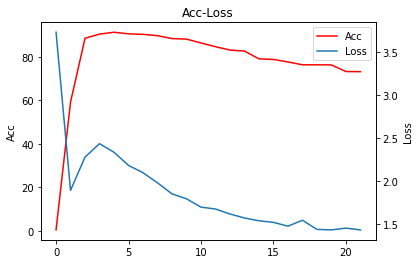

In [ ]:
S_acc2 =[S2.loss_acc[i][1]*100 for i in range(len(S2.loss_acc))]
S_loss2 =[S2.loss_acc[i][0] for i in range(len(S2.loss_acc))]

x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc2,'r',label='Acc')
ax1.set_ylabel('Acc')
ax1.set_title('Acc-Loss')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_loss2,label='Loss')
ax2.set_ylabel('Loss')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()

聚合轮数较多时，本文设计的算法能对性能下降起到一个缓冲作用

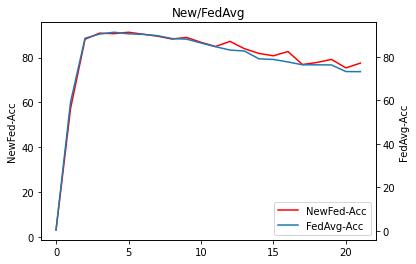

In [ ]:
x = np.arange(len(S2.loss_acc))
fig = plt.figure()
ax1 = fig.add_subplot(111)
acc = ax1.plot(x,S_acc,'r',label='NewFed-Acc')
ax1.set_ylabel('NewFed-Acc')
ax1.set_title('New/FedAvg')

ax2 = ax1.twinx()
loss = ax2.plot(x,S_acc2,label='FedAvg-Acc')
ax2.set_ylabel('FedAvg-Acc')

lns = acc+loss
labs = [l.get_label() for l in lns]
ax2.legend(lns,labs)
plt.show()